# Visualize Srilankan Crisis

### Goal of this notebook: To visualize the srilankan crisis (2007-2009) leveraging the GDELT data

### Acknowledgements/References:

#### Directly inspired by the paper : [Multi-level Analysis of Peace and Conflict Data in GDELT](https://www.researchgate.net/publication/269097432_Multi-level_Analysis_of_Peace_and_Conflict_Data_in_GDELT)

I have tried to replicate the events/dates/charts mentioned in the above paper

In [110]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
import datetime
from datetime import *
from dateutil.parser import parse
from pyspark.sql import SQLContext
from pyspark.sql.types import *
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
sc

In [3]:
#input: globalEventId (int), eventDate (date), eventMonth(int), eventYear(int), eventCode(int), 
# eventBaseCode (Int), eventRootCode (int), quadClass (int), goldsteinScale (float), 
#numArticles(int), avgTone(float), actionGeoCountryCode(string)
def parseCoreRdd(strRecord):
    rec = strRecord.split(',')
    return (int(rec[0]), parse(rec[1]).date(), int(rec[2]), int(rec[3]), int(rec[4]), \
            int(rec[5]), int(rec[6]), int(rec[7]), float(rec[8]), \
            int(rec[9]), float(rec[10]), rec[11])

coreDataRdd = sc.textFile("s3://gdeltdata/coredata/*").map(parseCoreRdd)

In [4]:
coreDataRdd.cache()

PythonRDD[2] at RDD at PythonRDD.scala:43

## Srilanka between 2007 and 2009

In [57]:
#Sort by date
def sortListsByFirstList(l1, l2):
    l1 = np.array(l1)
    l2 = np.array(l2)
    inds = l1.argsort()
    l1 = l1[inds]
    l2 = l2[inds]
    return l1, l2

In [5]:
srilankaRdd = coreDataRdd.filter(lambda x: x[11]=="CE" and x[3] >2006 and x[3] < 2010)

In [55]:
from operator import add
slEvents = srilankaRdd.map(lambda x: (x[1].replace(day=1),1)).reduceByKey(add).collect()

In [58]:
sl_dates, sl_count = zip(*slEvents)
sl_dates, sl_count = sortListsByFirstList(sl_dates, sl_count)

In [ ]:
ax2.

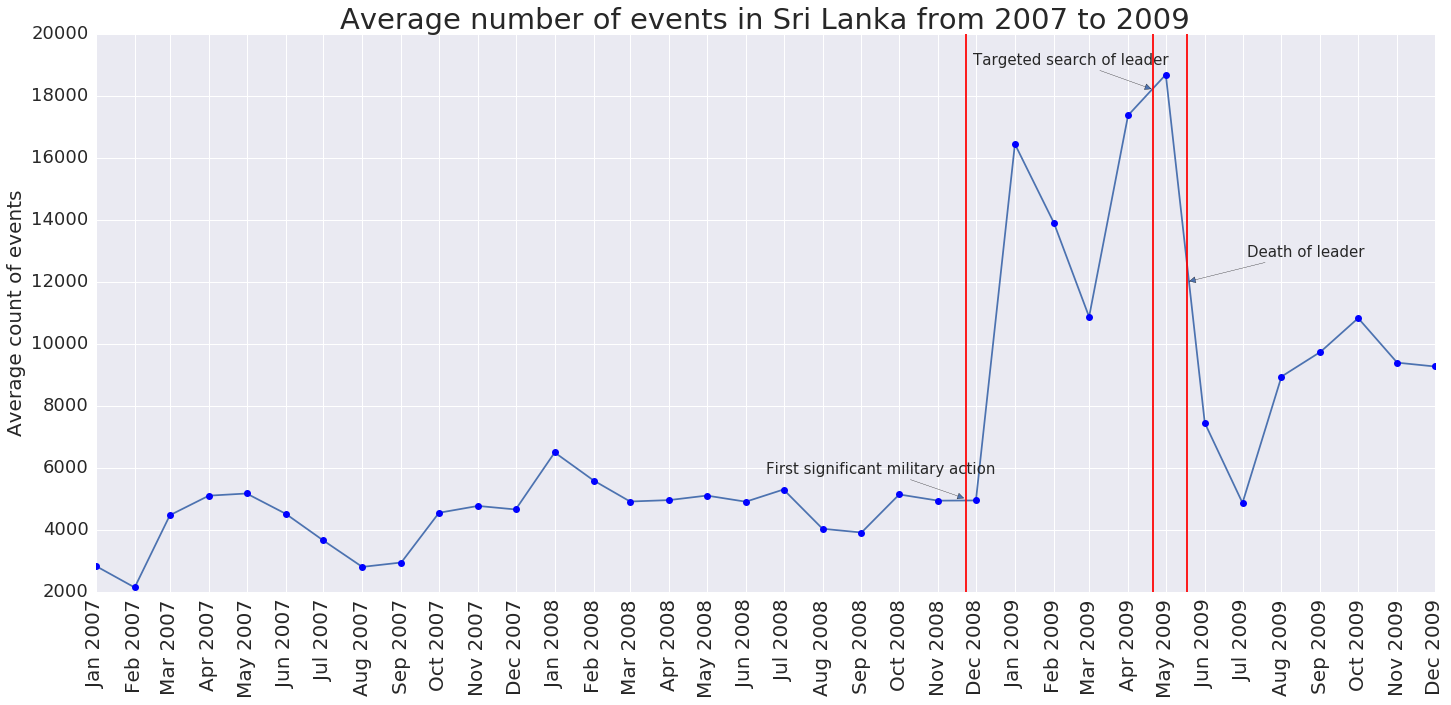

In [59]:
import matplotlib.dates as mdates
import datetime

strDates = [dd.strftime("%b %Y") for dd in sl_dates]
firstSignificantMilitaryAction = datetime.date(2008, 11, 23) #23 November 2008
targetedSearchOfLeader = datetime.date(2009, 4, 21) #21 april 2009
leaderDeath = datetime.date(2009, 5, 18)


plt.figure(figsize=(24,10))
plt.plot(sl_dates, sl_count)
plt.plot(sl_dates, sl_count, "bo")
plt.xticks(sl_dates, strDates, rotation='vertical', fontsize = 20)
plt.yticks(fontsize = 18)

plt.ylabel("Average count of events",  fontsize = 20)
plt.title("Average number of events in Sri Lanka from 2007 to 2009", fontsize = 29)

plt.axvline(firstSignificantMilitaryAction, color='r')
#plt.annotate('local max', xy=(2, 1), xytext=(3, 1.5))

plt.axvline(targetedSearchOfLeader, color='r')
plt.axvline(leaderDeath, color='r')



plt.annotate('First significant military action', (mdates.date2num(firstSignificantMilitaryAction), 5000), xytext=(-200, 25), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'), fontsize = 15)

plt.annotate('Targeted search of leader', (mdates.date2num(targetedSearchOfLeader), 18200), xytext=(-180, 25), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'), fontsize = 15)

plt.annotate('Death of leader', (mdates.date2num(leaderDeath), 12000), xytext=(60, 25), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'), fontsize = 15)

plt.show()

In [11]:
slEventsQuadClass = srilankaRdd.map(lambda x: ((x[1].replace(day=1), x[7]),1)).reduceByKey(add).collect()

In [51]:
qcDatesDict = {}
qcCountDict = {}

for i in np.arange(1,5):
    qcDatesDict[i] = []
    qcCountDict[i] = []

for item in slEventsQuadClass:
    qcEventDate = item[0][0]
    qcQuadClassEvent = item[0][1]    
    qcCount = item[1]
    qcDatesDict[qcQuadClassEvent].append(qcEventDate)
    qcCountDict[qcQuadClassEvent].append(qcCount)

In [61]:
#sortListsByFirstList
for i in np.arange(1,5):
    qcDatesDict[i], qcCountDict[i] = sortListsByFirstList(qcDatesDict[i], qcCountDict[i])

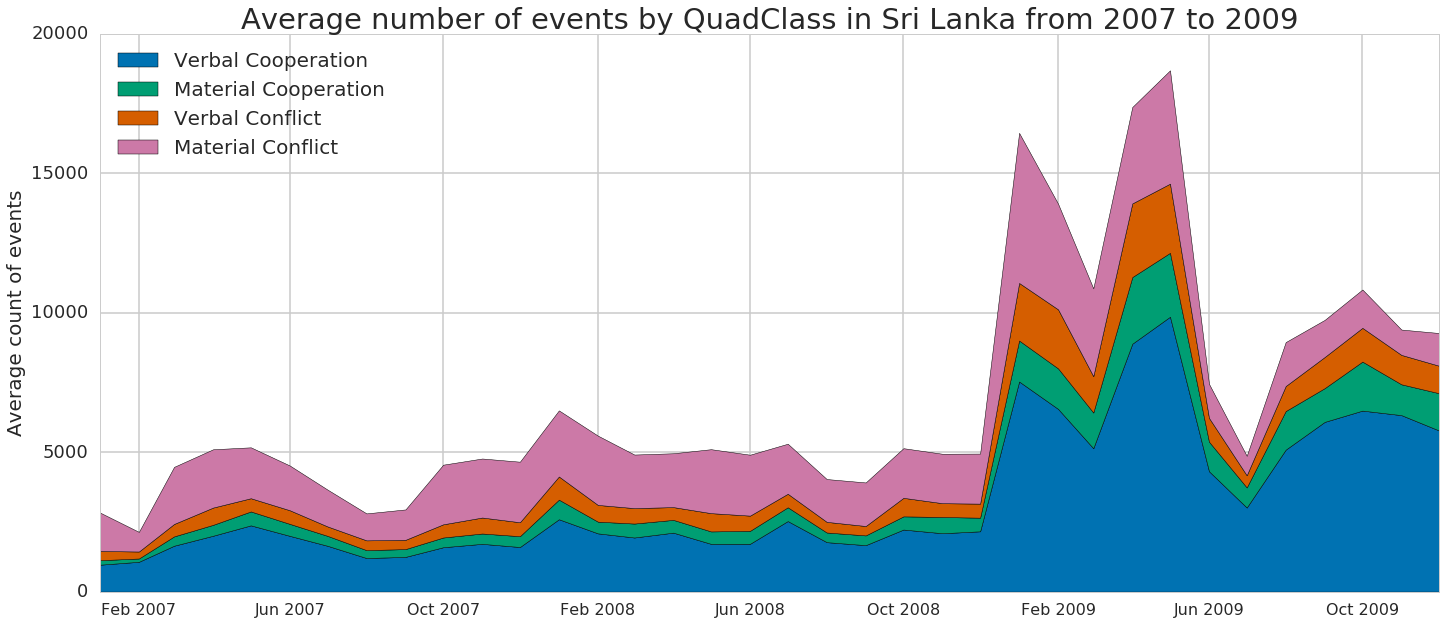

In [121]:
with sns.color_palette("colorblind"):
    plt.figure(figsize=(24,10))
    #plt.plot( qcDatesDict[2], qcCountDict[2])
    plt.stackplot(qcDatesDict[1],qcCountDict[1], qcCountDict[2], qcCountDict[3], qcCountDict[4],\
                  labels=["Verbal Cooperation","Material Cooperation","Verbal Conflict","Material Conflict"])
    #plt.xticks(sl_dates, strDates, rotation='vertical', fontsize = 20)
    plt.ylabel("Average count of events",  fontsize = 20)
    plt.title("Average number of events by QuadClass in Sri Lanka from 2007 to 2009", fontsize = 29)
    plt.legend(loc="upper left",prop={'size':20})
    plt.yticks(fontsize = 18)

# Appendix 1: Dataframe

In [4]:
def getCoreDataSchema():
    coreDataHeader = "globalEventId,eventDate,eventMonth,eventYear,eventCode,eventBaseCode,eventRootCode,quadClass,\
goldsteinScale,numArticles,avgTone,actionGeoCountryCode"
    
    #schemaString = header
    fields = [StructField(field_name, StringType(), True) for field_name in coreDataHeader.split(',')]
    print "# of columns: ", len(fields)

    fields[0].dataType = IntegerType()
    fields[1].dataType = DateType()
    fields[2].dataType = IntegerType()
    fields[3].dataType = IntegerType()
    fields[4].dataType = IntegerType()
    fields[5].dataType = IntegerType()
    fields[6].dataType = IntegerType()
    fields[7].dataType = IntegerType()
    fields[8].dataType = FloatType()
    fields[9].dataType = IntegerType()
    fields[10].dataType = FloatType()
    #fields[11]: is string

    coreDataSchema = StructType(fields)
    return coreDataSchema

In [5]:
coreDataRdd.cache()

PythonRDD[2] at RDD at PythonRDD.scala:43

In [ ]:
coreDataRdd.persist(org.apache.spark.storage.StorageLevel.MEMORY_ONLY)

In [ ]:
coreDataRdd

In [6]:
sqlContext = SQLContext(sc)
coreDataDF = sqlContext.createDataFrame(coreDataRdd, getCoreDataSchema())

# of columns:  12


In [ ]:
coreDataDF.cache()

In [ ]:
coreDataDF.count()

In [8]:
coreDataDF.is_cached

False

In [13]:
aa = parse("1981-05-15").date()

In [16]:
aa.replace(day = 1)

datetime.date(1981, 5, 1)

In [7]:
coreDataDF.show()

+-------------+----------+----------+---------+---------+-------------+-------------+---------+--------------+-----------+---------+--------------------+
|globalEventId| eventDate|eventMonth|eventYear|eventCode|eventBaseCode|eventRootCode|quadClass|goldsteinScale|numArticles|  avgTone|actionGeoCountryCode|
+-------------+----------+----------+---------+---------+-------------+-------------+---------+--------------+-----------+---------+--------------------+
|      1142215|1981-05-15|         5|     1981|       40|           40|            4|        1|           1.0|          5|6.0832443|                  SY|
|      1142220|1981-05-15|         5|     1981|       57|           57|            5|        1|           8.0|          2| 5.357143|                  RS|
|      1142222|1981-05-15|         5|     1981|      110|          110|           11|        3|          -2.0|          2| 7.586207|                  ES|
|      1142233|1981-05-15|         5|     1981|      194|          194|     

# Appendix 2: Sandbox for srilanka data

In [172]:
slEventsByRootCode = srilankaRdd.filter(lambda x: x[1]>datetime.date(2008, 12, 31)).\
map(lambda x: ((x[1].replace(day=1), x[6]),1)).reduceByKey(add).collect()

In [173]:
rootCodeDatesDict = {}
rootCodeCountDict = {}

for i in np.arange(1,21):
    rootCodeDatesDict[i] = []
    rootCodeCountDict[i] = []

for item in slEventsByRootCode:
    rootCodeEventDate = item[0][0]
    rootEventCode = item[0][1]    
    rootCodeCount = item[1]
    rootCodeDatesDict[rootEventCode].append(rootCodeEventDate)
    rootCodeCountDict[rootEventCode].append(rootCodeCount)

#sortListsByFirstList
for i in np.arange(1,21):
    rootCodeDatesDict[i], rootCodeCountDict[i] = sortListsByFirstList(rootCodeDatesDict[i], rootCodeCountDict[i])

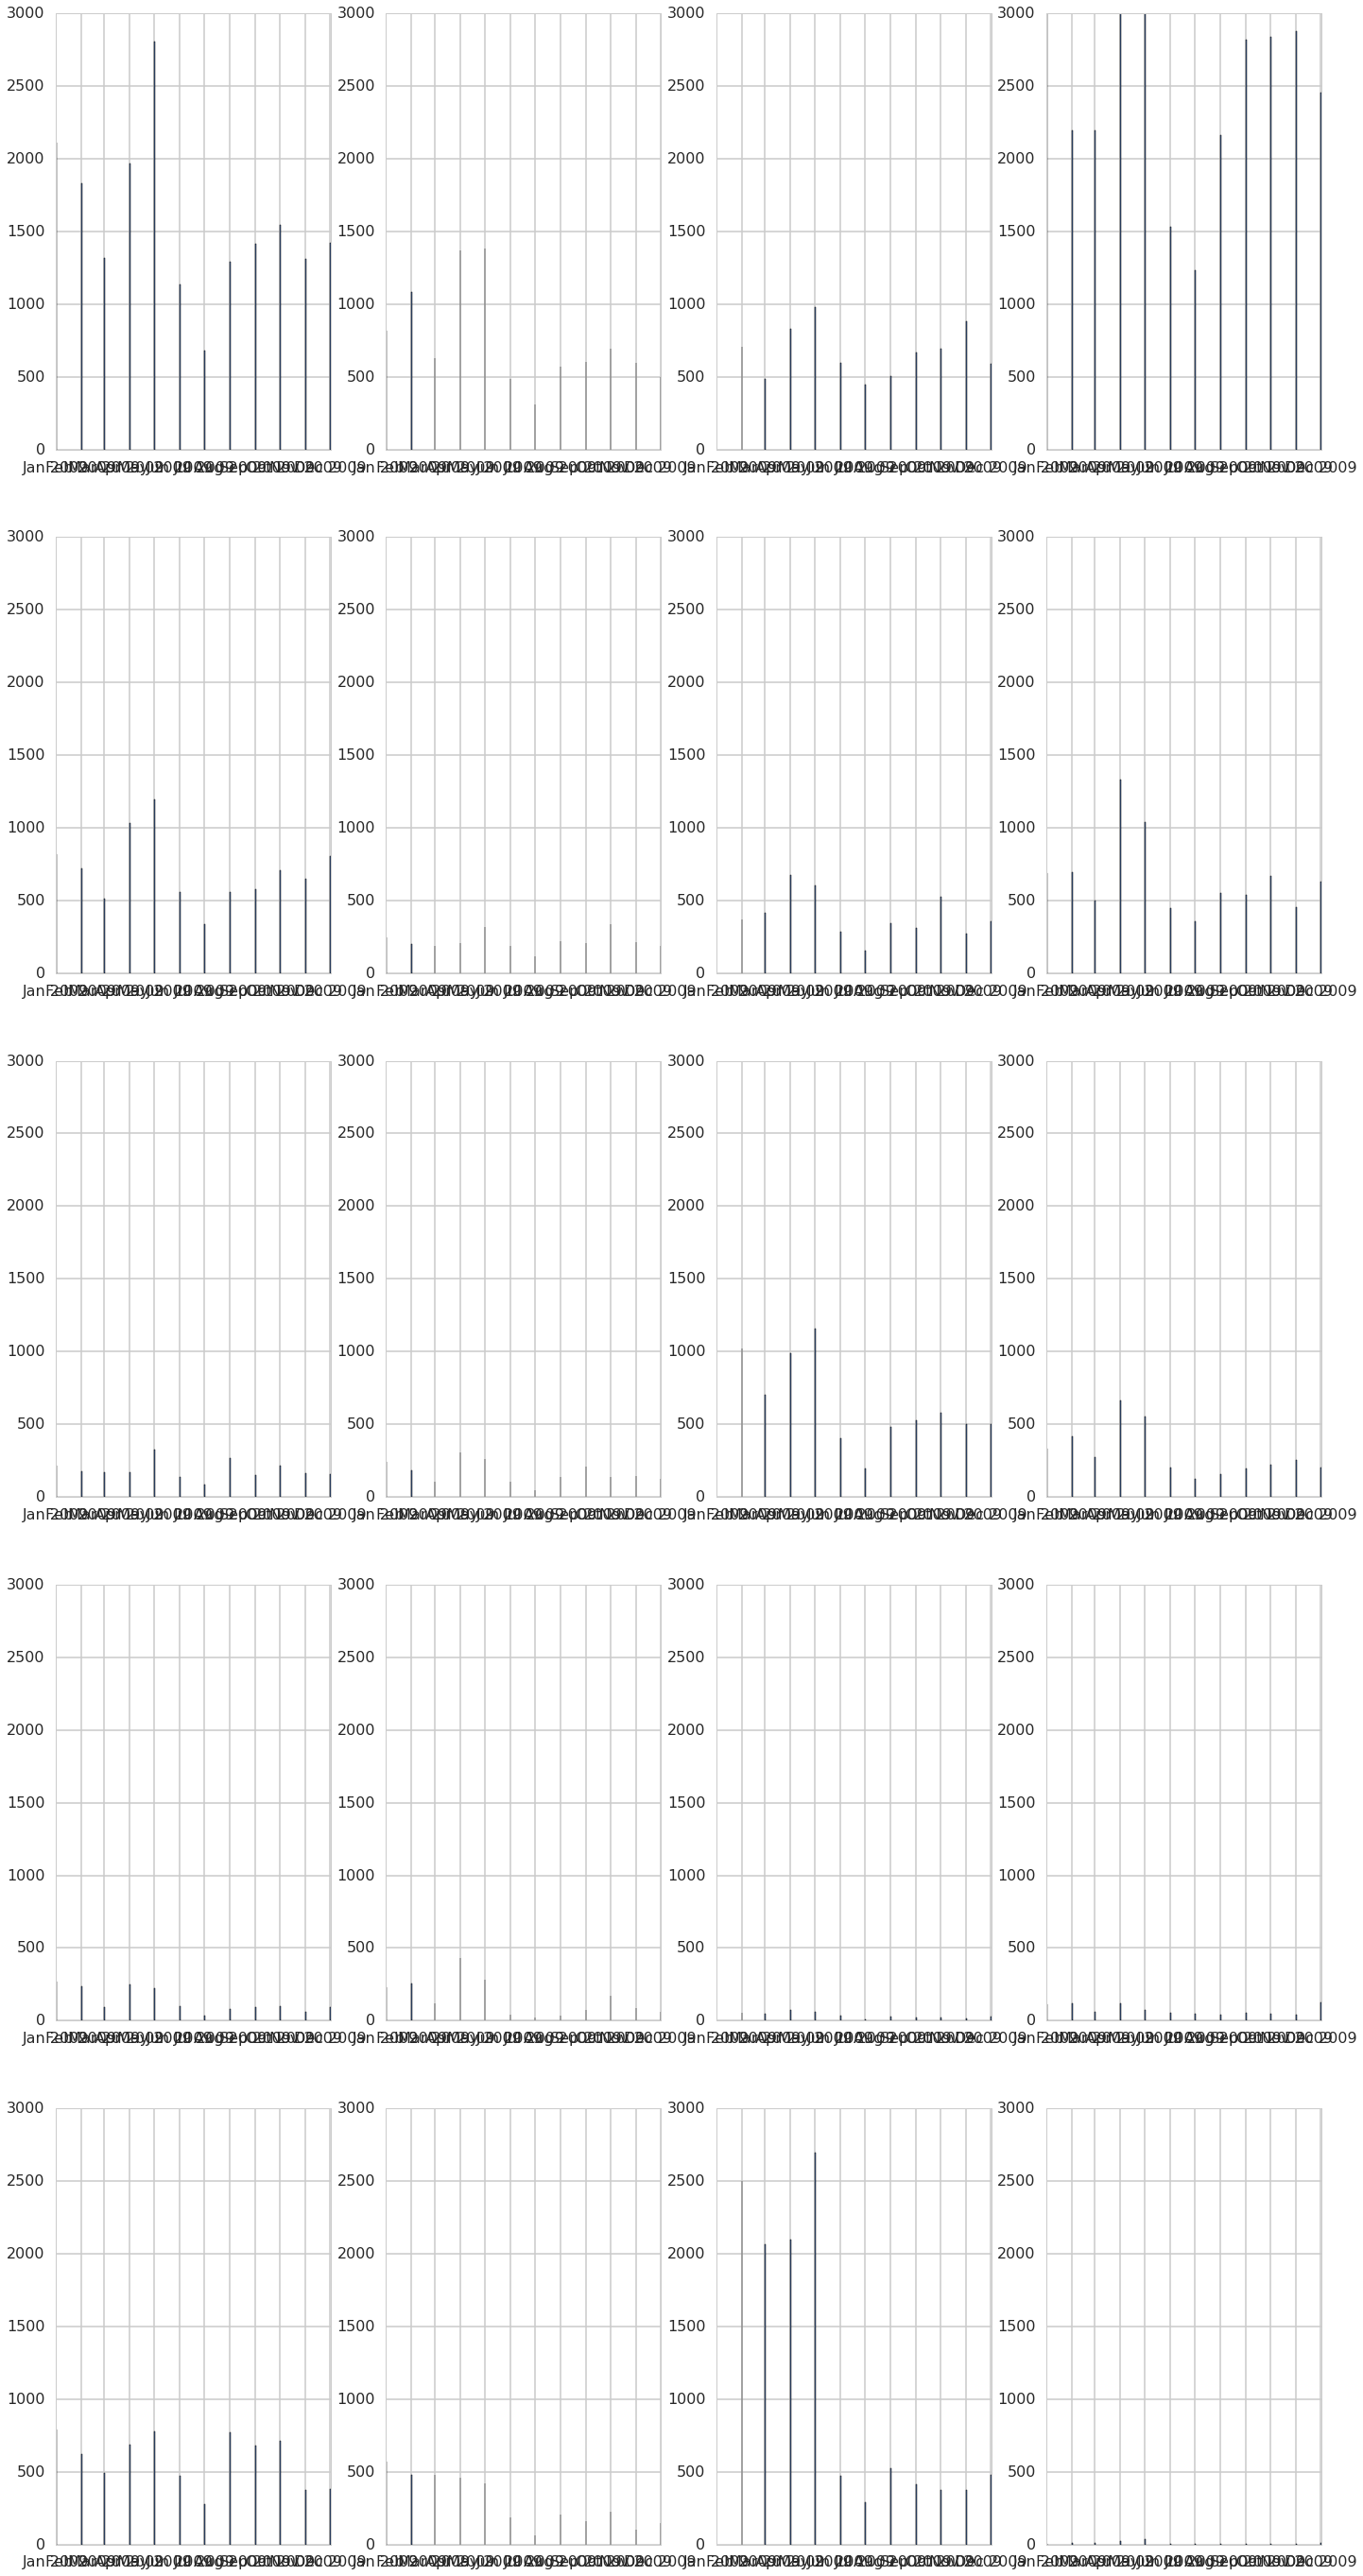

In [222]:
#with sns.color_palette("Set2"):
#plt.stackplot( qcDatesDict[1], qcCountDict[1])#, width=10)
#impRootEventCodes = [4,19,1,11,2,3] 
#impRootEventDesc = ["Consult", "Fight", "Make Public Statement"]

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(24, 48))
                         #tight_layout=True)

for ax, rootEventCode in zip(axes.ravel(), np.arange(1,21)):
    strDates = [dd.strftime("%b") for dd in rootCodeDatesDict[rootEventCode]]
    ax.bar(rootCodeDatesDict[rootEventCode], rootCodeCountDict[rootEventCode])
    #ax.xticks(np.arange(min(x), max(x)+1, datetime.timedelta(months=1)))
    #xloc =plt.MaxNLocator(4)
    #ax.xaxis.set_major_locator(xloc)
    #ax.locator_params(nbins=4)
    ax.set_xticks(rootCodeDatesDict[rootEventCode],strDates)
    ax.set_ylim(0,3000)
    
    
    
plt.show()